In [1]:
import pandas as np
df = np.read_csv('mbti_1.csv')

# populating types array
labels = []
for _type in df['type']:
     labels.append(_type)

In [2]:
import pickle

posts = []
with open ('processed_posts.pkl', 'rb') as fp:
    posts = pickle.load(fp)

In [3]:
tokenized_posts = []

for post in posts:
    user = []
    for sentence in post:
        user += sentence.split(" ")
        
    tokenized_posts.append(user)

In [4]:
all_words_list = []

for user in tokenized_posts:
    for word in user:
        all_words_list.append(word)

In [5]:
from collections import Counter

In [6]:
freq_list = Counter(all_words_list)
dictionary = freq_list.most_common(10000)

In [7]:
dictionary = list(zip(*dictionary))[0]

In [8]:
nums = range(0, 10000)
word_int = dict(zip(dictionary, nums))

In [9]:
x_vals = []
for user in tokenized_posts:
    x_vals.append([word_int[x] for x in user if x in word_int.keys()])

In [10]:
temp = []
for i in range(0,8675):
    row = []
    row.append(labels[i])
    row.append(x_vals[i])
    temp.append(row)

In [11]:
temp = sorted(temp)

In [12]:
x_train = []
y_train = []
x_test = []
y_test = []

In [15]:
labels = []
x_vals = []
for i in range(0, 8675):
    labels.append(temp[i][0])
    x_vals.append(temp[i][1])

In [17]:
current_type = labels[0]
counter = 0
last_change = 0

for i in range(0, 8675):
    if labels[i] != current_type or i == 8674:
        end_index = last_change + round(counter - counter/10)
        counter += last_change
        
        if (i == 8674):
            counter += 1
        
        for j in range(last_change, end_index):
            x_train.append(x_vals[j])
            y_train.append(labels[j])
        
        for j in range(end_index, counter):
            x_test.append(x_vals[j])
            y_test.append(labels[j])
        
        last_change = i
        counter = 1
        current_type = labels[i]
        continue
    counter += 1
        

In [18]:
type_dictionary = {
    '0000':'INTJ',
    '0001':'INTP',
    '0010':'INFJ',
    '0011':'INFP',
    '0100':'ISTJ',
    '0101':'ISTP',
    '0110':'ISFJ',
    '0111':'ISFP',
    '1000':'ENTJ',
    '1001':'ENTP',
    '1010':'ENFJ',
    '1011':'ENFP',
    '1100':'ESTJ',
    '1101':'ESTP',
    '1110':'ESFJ',
    '1111':'ESFP',
}

type_labels=['INTJ','INTP','INFJ','INFP','ISTJ','ISTP','ISFJ','ISFP', \
        'ENTJ','ENTP','ENFJ','ENFP','ESTJ','ESTP','ESFJ','ESFP',]

def to_one_hot(arr):
    one_hot_types = []

    for label in arr:
        bin_type = []

        if (label[0] == 'I'):
            bin_type.append(0)
        else:
            bin_type.append(1)

        if (label[1] == 'N'):
            bin_type.append(0)
        else:
            bin_type.append(1)

        if (label[2] == 'T'):
            bin_type.append(0)
        else:
            bin_type.append(1)

        if (label[3] == 'J'):
            bin_type.append(0)
        else:
            bin_type.append(1)

        one_hot_types.append(bin_type)
        
    return one_hot_types
    

In [19]:
import numpy as np
from keras.utils.np_utils import to_categorical

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(x_train)
x_test = vectorize_sequences(x_test)

y_train = np.asarray(to_one_hot(y_train)).astype('float32')
y_test = np.asarray(to_one_hot(y_test)).astype('float32')



Using TensorFlow backend.


In [20]:
class_weights = [{0:1, 1:3.3}, {0:1, 1:6.24}, {0:1, 1:1.18}, {0:1, 1:0.65}]

In [29]:
# FEED FORWARD MODEL
from keras import models
from keras import layers
from keras.regularizers import l2
import tensorflow as tf
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape = (10000,), kernel_regularizer=l2(0.001)))
    model.add(layers.Dense(16, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(layers.Dense(4, activation='sigmoid'))
    model.compile(optimizer = 'rmsprop',
                  loss = 'binary_crossentropy',
                  metrics = ['acc'])
    return model

In [23]:
from keras.callbacks import Callback

class True_eval(Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data
        self.accuracies = []
    
    def real_acc(self):
        x_val = self.validation_data[0]
        y_true = self.validation_data[1]
        y_pred = self.model.predict(x_val)
        acc = 0
        for i in range(0, len(y_pred)):
            if (y_pred[i].round().tolist() == y_true[i].tolist()):
                acc +=1
        return acc/len(y_pred)
    
    def on_epoch_end(self, epoch, logs={}):
        real_acc = self.real_acc()
        print ("Real Accuracy: %f" % real_acc)
        self.accuracies.append(real_acc)
        
true_metrics = True_eval((x_test, y_test))

In [25]:
model = build_model()
with tf.device('/gpu:0'):
    history = model.fit(x_train, y_train, validation_data= (x_test, y_test), epochs = 60, batch_size = 512, callbacks=[true_metrics], class_weight=class_weights)

Train on 7806 samples, validate on 869 samples
Epoch 1/60
7806/7806 [==============================] - 1s 173us/step - loss: 0.6191 - categorical_accuracy: 0.2921 - val_loss: 0.6066 - val_categorical_accuracy: 0.1565
Real Accuracy: 0.216341
Epoch 2/60
7806/7806 [==============================] - 1s 95us/step - loss: 0.5655 - categorical_accuracy: 0.3337 - val_loss: 0.5733 - val_categorical_accuracy: 0.3659
Real Accuracy: 0.318757
Epoch 3/60
7806/7806 [==============================] - 1s 97us/step - loss: 0.5330 - categorical_accuracy: 0.3768 - val_loss: 0.5579 - val_categorical_accuracy: 0.3326
Real Accuracy: 0.321059
Epoch 4/60
7806/7806 [==============================] - 1s 90us/step - loss: 0.5118 - categorical_accuracy: 0.4040 - val_loss: 0.5511 - val_categorical_accuracy: 0.4120
Real Accuracy: 0.337169
Epoch 5/60
7806/7806 [==============================] - 1s 89us/step - loss: 0.4889 - categorical_accuracy: 0.4299 - val_loss: 0.5436 - val_categorical_accuracy: 0.3245
Real Accura

KeyboardInterrupt: 

In [36]:
model = build_model()
with tf.device('/gpu:0'):
    model.fit(x_train, y_train, epochs = 40, batch_size = 128, class_weight=class_weights)
    y_pred = model.predict(x_test)
    results = model.evaluate(x_test, y_test)
results

Epoch 1/40
7806/7806 [==============================] - 1s 160us/step - loss: 0.5983 - acc: 0.7152
Epoch 2/40
7806/7806 [==============================] - 1s 105us/step - loss: 0.5246 - acc: 0.7667
Epoch 3/40
7806/7806 [==============================] - 1s 106us/step - loss: 0.4787 - acc: 0.7938
Epoch 4/40
7806/7806 [==============================] - 1s 105us/step - loss: 0.4429 - acc: 0.8182
Epoch 5/40
7806/7806 [==============================] - 1s 106us/step - loss: 0.4142 - acc: 0.8349
Epoch 6/40
7806/7806 [==============================] - 1s 106us/step - loss: 0.3937 - acc: 0.8488
Epoch 7/40
7806/7806 [==============================] - 1s 106us/step - loss: 0.3727 - acc: 0.8652
Epoch 8/40
7806/7806 [==============================] - 1s 107us/step - loss: 0.3539 - acc: 0.8795
Epoch 9/40
7806/7806 [==============================] - 1s 106us/step - loss: 0.3398 - acc: 0.8884
Epoch 10/40
7806/7806 [==============================] - 1s 105us/step - loss: 0.3265 - acc: 0.8986
Epoch 11/

[1.0007600497595872, 0.7410817029698397]

Normalized confusion matrix


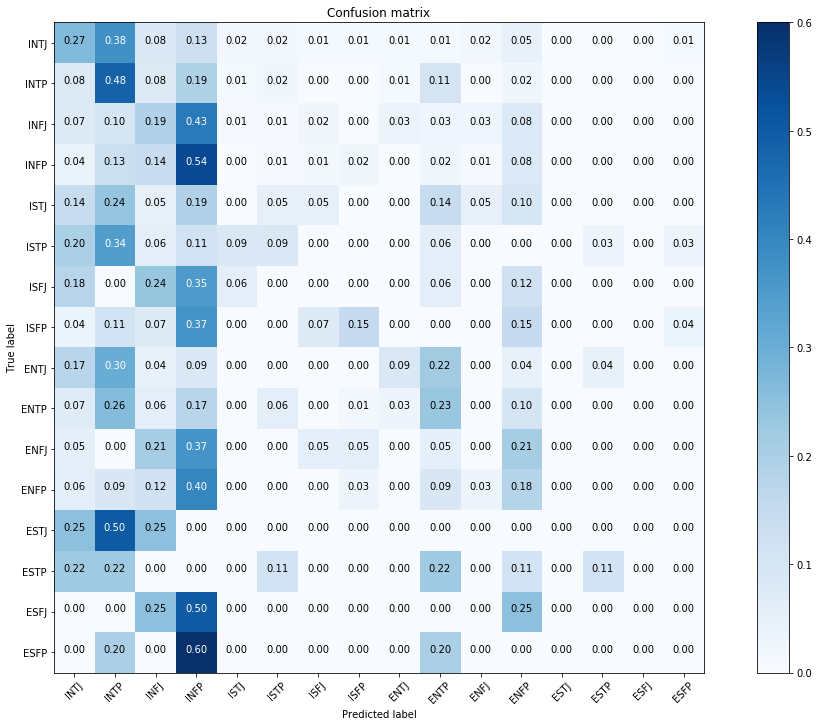

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

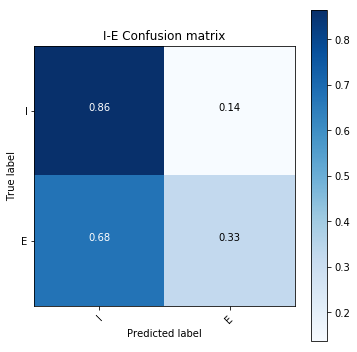

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

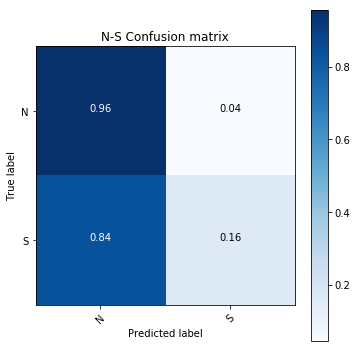

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

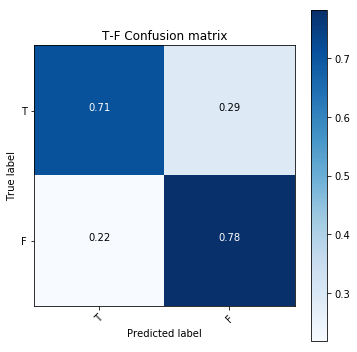

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

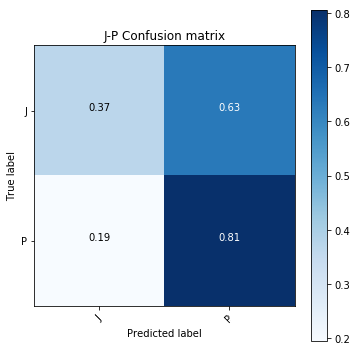

In [37]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import datetime

now = datetime.datetime.now()
pictures = []
folder = "FF"

def byte_to_mbti(byte):
    binary = ''
    for letter in byte:
         binary +=(str(int(letter)))        
    return type_dictionary[binary]

decoded_y_true = [byte_to_mbti(label) for label in y_test.round()]
decoded_y_pred = [byte_to_mbti(label) for label in y_pred.round()]

matrix = confusion_matrix(decoded_y_true, decoded_y_pred, labels=type_labels)
matrix_I_E = confusion_matrix(y_test[:,0], y_pred[:,0].round(), labels=[0, 1])
matrix_N_S = confusion_matrix(y_test[:,1], y_pred[:,1].round(), labels=[0, 1])
matrix_T_F = confusion_matrix(y_test[:,2], y_pred[:,2].round(), labels=[0, 1])
matrix_J_P = confusion_matrix(y_test[:,3], y_pred[:,3].round(), labels=[0, 1])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plt.figure(figsize=(15,10))
plot_confusion_matrix(matrix, classes=type_labels, normalize=True,
                      title='Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM0.png"
plt.savefig(name)
plt.show()
pictures.append(name)

plt.clf()
plt.figure(figsize=(5,5))
plot_confusion_matrix(matrix_I_E, classes=["I", "E"], normalize=True,
                      title='I-E Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM1.png"
plt.savefig(name)
plt.show()
pictures.append(name)

plt.clf()
plt.figure(figsize=(5,5))
plot_confusion_matrix(matrix_N_S, classes=["N", "S"], normalize=True,
                      title='N-S Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM2.png"
plt.savefig(name)
plt.show()
pictures.append(name)

plt.clf()
plt.figure(figsize=(5,5))
plot_confusion_matrix(matrix_T_F, classes=["T", "F"], normalize=True,
                      title='T-F Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM3.png"
plt.savefig(name)
plt.show()
pictures.append(name)

plt.clf()
plt.figure(figsize=(5,5))
plot_confusion_matrix(matrix_J_P, classes=["J", "P"], normalize=True,
                      title='J-P Confusion matrix')
name = str(folder) + "/" + str(now.month) + "-" + str(now.day) + "-" + \
str(now.hour) + "-" + str(now.minute) + "_" + "CM4.png"
plt.savefig(name)
plt.show()
pictures.append(name)

In [ ]:
acc = 0
for i in range(0, len(y_test)):
    if (y_pred[i].round().tolist() == y_test[i].tolist()):
        acc +=1
        
acc/len(y_test)

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

train_acc = history_dict['acc']
val_acc   = history_dict['val_acc']

epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, train_acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
def myprint(s):
    with open('results.log','a+') as f:
        print(s, file=f)
    f.close()
        
log_file = open('results.log', 'a+')

log_file.write("\n=================================================================")
log_file.write( "\n" + str(now.month) + "/" + str(now.day) + "/" + str(now.year) + " " + \
str(now.hour) + ":" + str(now.minute) + ":" + str(now.second) + "\n")

log_file.close()

model.summary(print_fn=myprint)

log_file = open('results.log', 'a+')

log_file.write("Results:\t" + str(results) + "\n")

log_file.write("Images:\n")
log_file.write("\t" + pictures[0] + "\n")
log_file.write("\t" + pictures[1] + "\n")
log_file.write("\t" + pictures[2] + "\n")
log_file.write("\t" + pictures[3] + "\n")
log_file.write("\t" + pictures[4] + "\n")

log_file.close()